# <center>Quantum Neural Networks - Code</center>

### <center>Devarshi Joshi - 202003007</center>
### <center>Arpan Shingala - 202003013</center>

In [40]:
pip install scikit-learn==1.2.1 -q

Note: you may need to restart the kernel to use updated packages.


In [41]:
pip install tensorflow==2.9.1 -q

Note: you may need to restart the kernel to use updated packages.


In [42]:
pip install pennylane==0.26 -q

Note: you may need to restart the kernel to use updated packages.


In [43]:
pip install qiskit_machine_learning==0.5.0 -q

Note: you may need to restart the kernel to use updated packages.


In [44]:
!pip install matplotlib -q

In [6]:
import pennylane as qml
import numpy as np
import tensorflow as tf

seed = 4321
np.random.seed(seed)
tf.random.set_seed(seed)

In [7]:
#importing keras
import keras
#importing sequential module
from keras.models import Sequential
# import dense module for hidden layers
from keras.layers import Dense
#importing activation functions
from keras.layers import LeakyReLU,PReLU,ELU
from keras.layers import Dropout

In [8]:
tf.keras.backend.set_floatx('float64')

In [9]:
from sklearn.datasets import load_breast_cancer

x,y = load_breast_cancer(return_X_y = True)

In [10]:
from sklearn.model_selection import train_test_split

x_tr, x_test, y_tr, y_test = train_test_split(
    x, y, train_size = 0.8)
x_val, x_test, y_val, y_test = train_test_split(
    x_test, y_test, train_size = 0.5)

In [11]:
from sklearn.preprocessing import MaxAbsScaler

scaler = MaxAbsScaler()
x_tr = scaler.fit_transform(x_tr)

In [12]:
x_test = scaler.transform(x_test)
x_val = scaler.transform(x_val)

# Restrict all the values to be between 0 and 1.
x_test = np.clip(x_test, 0, 1)
x_val = np.clip(x_val, 0, 1)

In [13]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 4)

xs_tr = pca.fit_transform(x_tr)
xs_test = pca.transform(x_test)
xs_val = pca.transform(x_val)

# Classical NN

In [14]:
#creating model
classifier = Sequential()

2023-05-10 13:50:05.686695: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [15]:
#first hidden layer
classifier.add(Dense(units=9,kernel_initializer='he_uniform',activation='relu',input_dim=30))
# last layer or output layer
classifier.add(Dense(units=1,kernel_initializer='glorot_uniform',activation='sigmoid'))

In [16]:
#compiling the ANN
classifier.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [17]:
#fitting the ANN to the training set
model = classifier.fit(x_tr, y_tr, epochs = 100, shuffle = True, batch_size = 20)

Epoch 1/100
23/23 [==============================] - 0s 1ms/step - loss: 0.6634 - accuracy: 0.6286
Epoch 2/100
23/23 [==============================] - 0s 1ms/step - loss: 0.6343 - accuracy: 0.6286
Epoch 3/100
23/23 [==============================] - 0s 1ms/step - loss: 0.6151 - accuracy: 0.6286
Epoch 4/100
23/23 [==============================] - 0s 1ms/step - loss: 0.5927 - accuracy: 0.6286
Epoch 5/100
23/23 [==============================] - 0s 1ms/step - loss: 0.5734 - accuracy: 0.6286
Epoch 6/100
23/23 [==============================] - 0s 1ms/step - loss: 0.5564 - accuracy: 0.6352
Epoch 7/100
23/23 [==============================] - 0s 1ms/step - loss: 0.5414 - accuracy: 0.6549
Epoch 8/100
23/23 [==============================] - 0s 1ms/step - loss: 0.5276 - accuracy: 0.6659
Epoch 9/100
23/23 [==============================] - 0s 1ms/step - loss: 0.5151 - accuracy: 0.6989
Epoch 10/100
23/23 [==============================] - 0s 1ms/step - loss: 0.5025 - accuracy: 0.7143
Epoch 11/

In [18]:
from sklearn.metrics import accuracy_score

tr_acc0 = accuracy_score(classifier.predict(x_tr) >= 0.5, y_tr)
val_acc0 = accuracy_score(classifier.predict(x_val) >= 0.5, y_val)
test_acc0 = accuracy_score(classifier.predict(x_test) >= 0.5, y_test)

print("Train accuracy:", tr_acc0)
print("Validation accuracy:", val_acc0)
print("Test accuracy:", test_acc0)

2/2 [==============================] - 0s 3ms/step
Train accuracy: 0.9494505494505494
Validation accuracy: 0.9122807017543859
Test accuracy: 0.8947368421052632


# QNN - 1st model

In [19]:
from itertools import combinations

def ZZFeatureMap(nqubits, data):

    # Number of variables that we will load:
    # could be smaller than the number of qubits.
    nload = min(len(data), nqubits) 

    for i in range(nload):
        qml.Hadamard(i)
        qml.RZ(2.0 * data[i], wires = i)

    for pair in list(combinations(range(nload), 2)):
        q0 = pair[0]
        q1 = pair[1]

        qml.CZ(wires = [q0, q1])
        qml.RZ(2.0 * (np.pi - data[q0]) *
            (np.pi - data[q1]), wires = q1)
        qml.CZ(wires = [q0, q1])

def TwoLocal(nqubits, theta, reps = 1):
    
    for r in range(reps):
        for i in range(nqubits):
            qml.RY(theta[r * nqubits + i], wires = i)
        for i in range(nqubits - 1):
            qml.CNOT(wires = [i, i + 1])
    
    for i in range(nqubits):
        qml.RY(theta[reps * nqubits + i], wires = i)

In [20]:
state_0 = [[1], [0]]
M = state_0 * np.conj(state_0).T

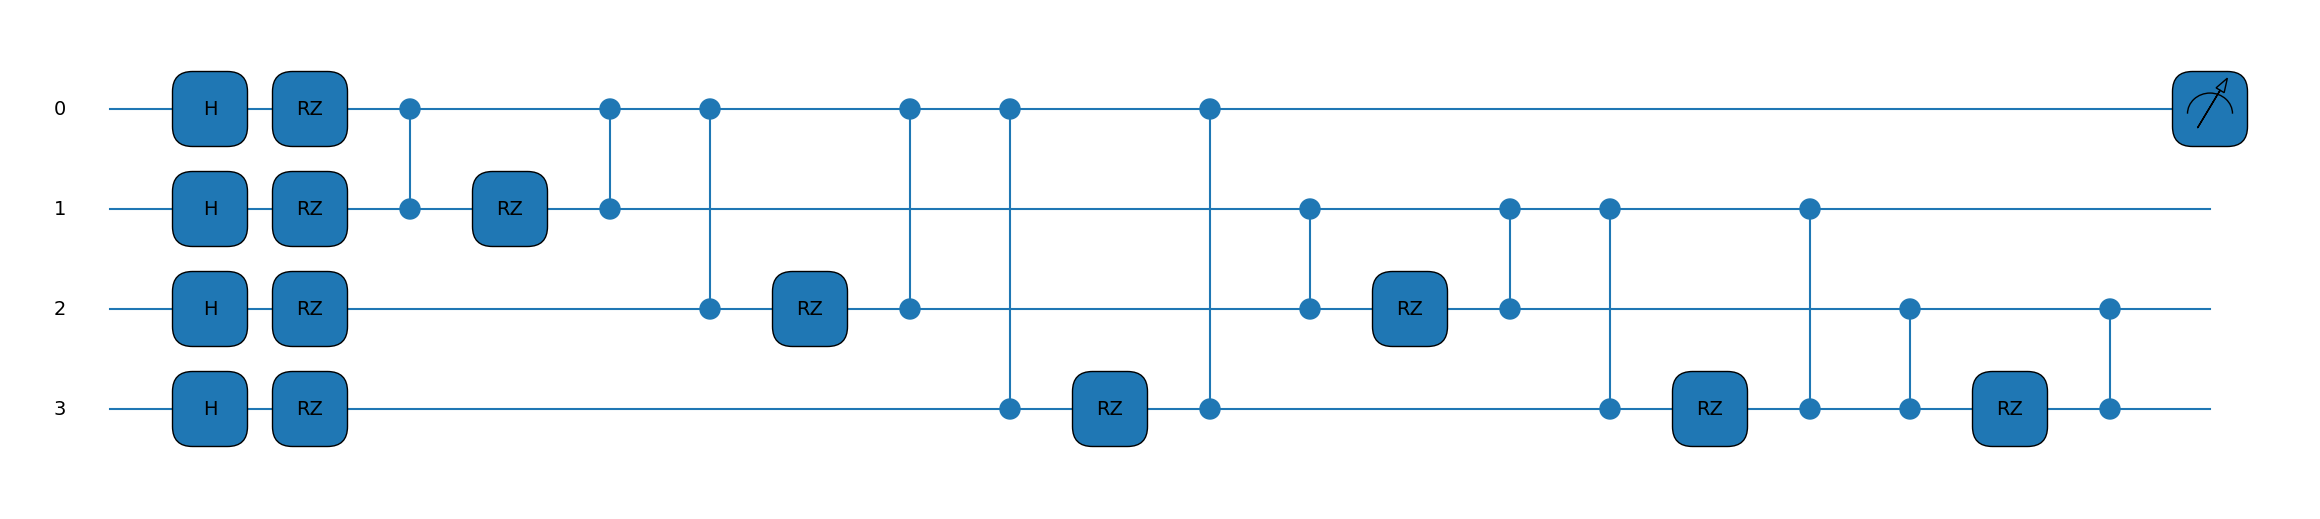

In [21]:
nqubits = 4
dev = qml.device("default.qubit", wires=nqubits)

@qml.qnode(dev)   
def qnn_circuit_ZZ(data):
    nload = min(len(data), nqubits) 

    for i in range(nload):
        qml.Hadamard(i)
        qml.RZ(2.0 * data[i], wires = i)

    for pair in list(combinations(range(nload), 2)):
        q0 = pair[0]
        q1 = pair[1]

        qml.CZ(wires = [q0, q1])
        qml.RZ(2.0 * (np.pi - data[q0]) * (np.pi - data[q1]), wires = q1)
        qml.CZ(wires = [q0, q1])
        
    return qml.expval(qml.Hermitian(M, wires = [0]))

fig, ax = qml.draw_mpl(qnn_circuit_ZZ)(xs_tr[0])
fig.show()

In the above circuit, we do not actually measure anything, we just use ZZ mapping to convert data into the required format. However, the circuit wouldnt print if we did not meausure anything. So, the measurement is a dummy value.

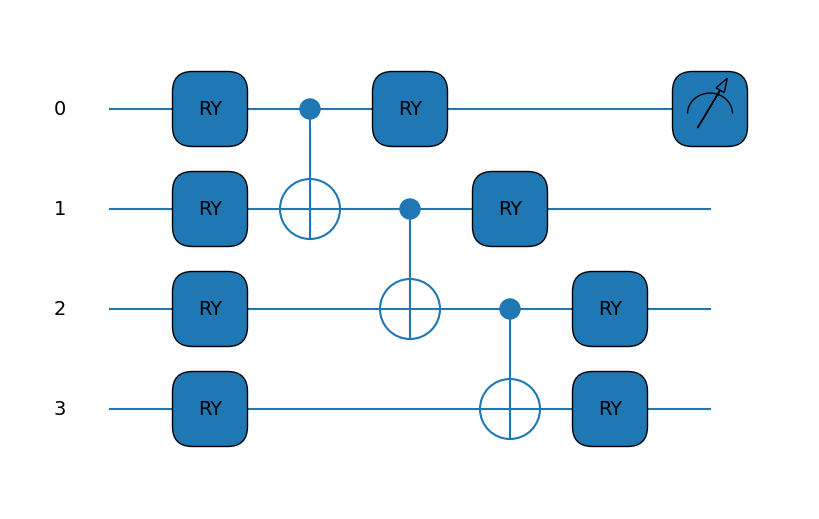

In [22]:
@qml.qnode(dev)   
def qnn_circuit_TL(theta):
    # print(theta.shape)
    # print(theta)
    reps = 1
    for r in range(reps):
        for i in range(nqubits):
            qml.RY(theta[r * nqubits + i], wires = i)
        for i in range(nqubits - 1):
            qml.CNOT(wires = [i, i + 1])
    
    for i in range(nqubits):
        qml.RY(theta[(reps * nqubits + i)], wires = i)
    
    return qml.expval(qml.Hermitian(M, wires = [0]))


theta = np.random.rand(8)

fig, ax = qml.draw_mpl(qnn_circuit_TL)(theta)
fig.show()

In [23]:
nqubits = 4
dev = qml.device("default.qubit", wires=nqubits)
def qnn_circuit(inputs, theta):
    ZZFeatureMap(nqubits, inputs)
    TwoLocal(nqubits = nqubits, theta = theta, reps = 1)
    return qml.expval(qml.Hermitian(M, wires = [0]))

# qnn = qml.QNode(qnn_circuit, dev, interface="tf")
qnn = qml.QNode(qnn_circuit, dev)

In [24]:
weights = {"theta": 8}
qlayer = qml.qnn.KerasLayer(qnn, weights, output_dim=1)

In [25]:
model = tf.keras.models.Sequential([qlayer])

In [26]:
opt = tf.keras.optimizers.Adam(learning_rate = 0.009)
model.compile(opt, loss=tf.keras.losses.BinaryCrossentropy())

In [27]:
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor = "val_loss", patience = 2, verbose = 1,
    restore_best_weights = True)

In [28]:
history = model.fit(xs_tr, y_tr, epochs = 100, shuffle = True,
    validation_data = (xs_val, y_val),
    batch_size = 20, 
    callbacks = [earlystop]
                   )

Epoch 1/100
23/23 [==============================] - 29s 1s/step - loss: 0.8410 - val_loss: 0.7652
Epoch 2/100
23/23 [==============================] - 32s 1s/step - loss: 0.7363 - val_loss: 0.6891
Epoch 3/100
23/23 [==============================] - 31s 1s/step - loss: 0.6676 - val_loss: 0.6435
Epoch 4/100
23/23 [==============================] - 32s 1s/step - loss: 0.6287 - val_loss: 0.6182
Epoch 5/100
23/23 [==============================] - 30s 1s/step - loss: 0.6070 - val_loss: 0.6053
Epoch 6/100
23/23 [==============================] - 32s 1s/step - loss: 0.5951 - val_loss: 0.6000
Epoch 7/100
23/23 [==============================] - 29s 1s/step - loss: 0.5892 - val_loss: 0.5982
Epoch 8/100
23/23 [==============================] - 34s 1s/step - loss: 0.5859 - val_loss: 0.5973
Epoch 9/100
23/23 [==============================] - 31s 1s/step - loss: 0.5839 - val_loss: 0.5983
Epoch 10/100
23/23 [==============================] - 33s 1s/step - loss: 0.5831 - val_loss: 0.5990
Epoch 10:

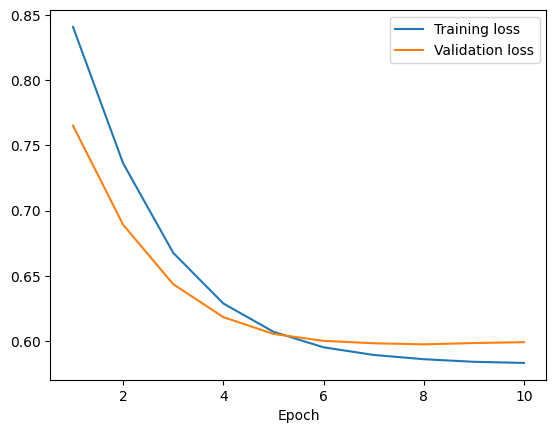

In [29]:
import matplotlib.pyplot as plt

def plot_losses(history):
    tr_loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = np.array(range(len(tr_loss))) + 1
    plt.plot(epochs, tr_loss, label = "Training loss")
    plt.plot(epochs, val_loss, label = "Validation loss")
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()

plot_losses(history)

In [30]:
from sklearn.metrics import accuracy_score

tr_acc1 = accuracy_score(model.predict(xs_tr) >= 0.5, y_tr)
val_acc1 = accuracy_score(model.predict(xs_val) >= 0.5, y_val)
test_acc1 = accuracy_score(model.predict(xs_test) >= 0.5, y_test)

print("Train accuracy:", tr_acc1)
print("Validation accuracy:", val_acc1)
print("Test accuracy:", test_acc1)

2/2 [==============================] - 2s 969ms/step
Train accuracy: 0.7120879120879121
Validation accuracy: 0.7192982456140351
Test accuracy: 0.7192982456140351


# QNN - 2nd model

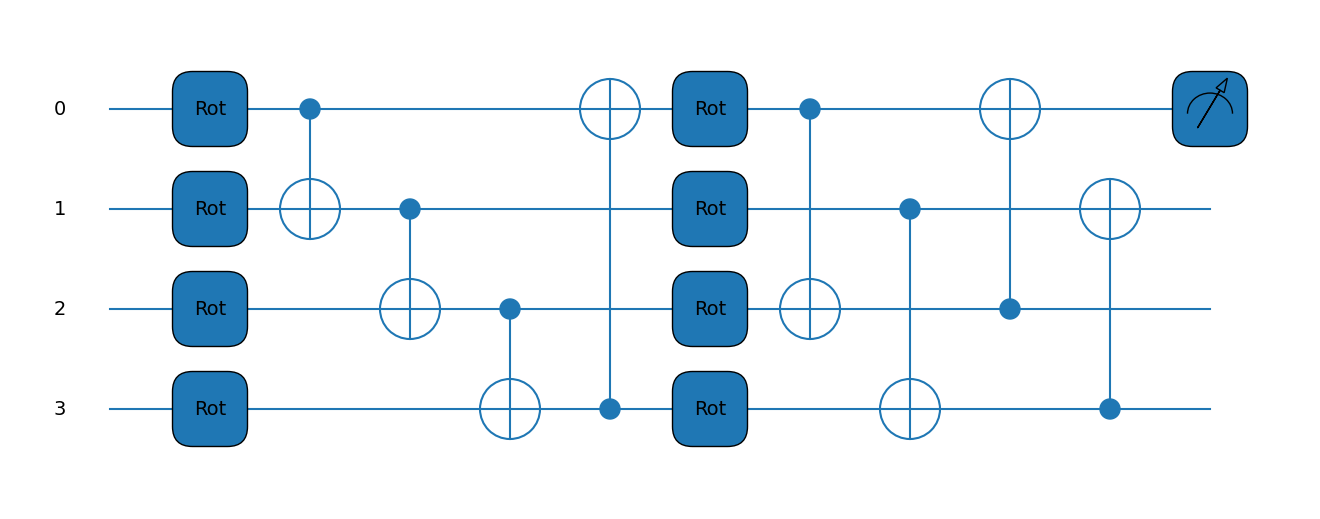

In [31]:
nqubits = 4
dev = qml.device("default.qubit", wires=nqubits)

nreps = 2 
weights_dim = qml.StronglyEntanglingLayers.shape(
    n_layers = nreps, n_wires = nqubits)
nweights = 3 * nreps * nqubits

@qml.qnode(dev)   
def qnn_circuit_strong_cir(theta):       
    
    theta1 = tf.reshape(theta, weights_dim)
    qml.StronglyEntanglingLayers(weights = theta1,
                                 wires = range(nqubits))
    
    return qml.expval(qml.Hermitian(M, wires = [0]))

theta = np.random.rand(nweights)
fig, ax = qml.draw_mpl(qnn_circuit_strong_cir, expansion_strategy="device")(theta)
fig.show()

In [32]:
nqubits = 4
dev = qml.device("default.qubit", wires=nqubits)

nreps = 2 
weights_dim = qml.StronglyEntanglingLayers.shape(
    n_layers = nreps, n_wires = nqubits)
nweights = 3 * nreps * nqubits

def qnn_circuit_strong(inputs, theta):
    
    ZZFeatureMap(nqubits, inputs)
    theta1 = tf.reshape(theta, weights_dim)
    qml.StronglyEntanglingLayers(weights = theta1,
                                 wires = range(nqubits))
    
    return qml.expval(qml.Hermitian(M, wires = [0]))

qnn_strong = qml.QNode(qnn_circuit_strong, dev)

In [33]:
weights_strong = {"theta": nweights}
qlayer_strong = qml.qnn.KerasLayer(qnn_strong, weights_strong, output_dim=1)

In [34]:
model_strong = tf.keras.models.Sequential([qlayer_strong])

In [35]:
opt_strong = tf.keras.optimizers.Adam(learning_rate = 0.009)
model_strong.compile(opt_strong, loss=tf.keras.losses.BinaryCrossentropy())

In [36]:
earlystop_strong = tf.keras.callbacks.EarlyStopping(
    monitor = "val_loss", patience = 2, verbose = 1,
    restore_best_weights = True)

In [37]:
history_strong = model_strong.fit(xs_tr, y_tr, epochs = 100, shuffle = True,
    validation_data = (xs_val, y_val),
    batch_size = 20, 
    callbacks = [earlystop_strong]
                                 )

Epoch 1/100
23/23 [==============================] - 47s 2s/step - loss: 0.6947 - val_loss: 0.6920
Epoch 2/100
23/23 [==============================] - 47s 2s/step - loss: 0.6929 - val_loss: 0.6908
Epoch 3/100
23/23 [==============================] - 48s 2s/step - loss: 0.6908 - val_loss: 0.6879
Epoch 4/100
23/23 [==============================] - 46s 2s/step - loss: 0.6851 - val_loss: 0.6791
Epoch 5/100
23/23 [==============================] - 49s 2s/step - loss: 0.6733 - val_loss: 0.6720
Epoch 6/100
23/23 [==============================] - 51s 2s/step - loss: 0.6657 - val_loss: 0.6708
Epoch 7/100
23/23 [==============================] - 50s 2s/step - loss: 0.6620 - val_loss: 0.6714
Epoch 8/100
23/23 [==============================] - 49s 2s/step - loss: 0.6606 - val_loss: 0.6711
Epoch 8: early stopping


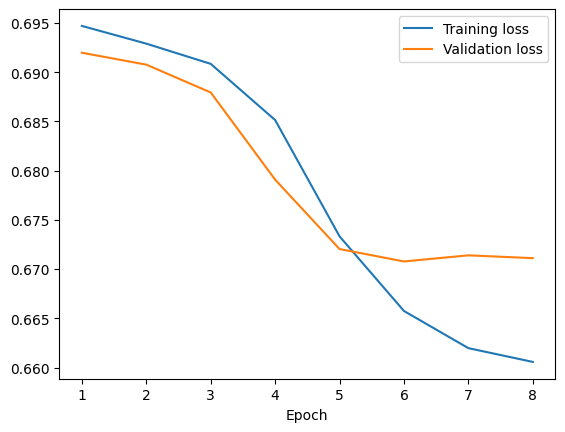

In [38]:
plot_losses(history_strong)

In [39]:
from sklearn.metrics import accuracy_score

tr_acc2 = accuracy_score(model_strong.predict(xs_tr) >= 0.5, y_tr)
val_acc2 = accuracy_score(model_strong.predict(xs_val) >= 0.5, y_val)
test_acc2 = accuracy_score(model_strong.predict(xs_test) >= 0.5, y_test)

print("Train accuracy:", tr_acc2)
print("Validation accuracy:", val_acc2)
print("Test accuracy:", test_acc2)

2/2 [==============================] - 4s 1s/step
Train accuracy: 0.5978021978021978
Validation accuracy: 0.5964912280701754
Test accuracy: 0.5964912280701754
